In [1]:
import torch
import torch.nn as nn
import sys
sys.path.append("/kaggle/working/")
from torch.utils.data import DataLoader 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [24]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
BS = 8
LR = 1e-5
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 100
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_GEN_H = "genh.pth.tar"
CHECKPOINT_GEN_Z = "genz.pth.tar"
CHECKPOINT_DISC_H = "critich.pth.tar"
CHECKPOINT_DISC_Z = "criticz.pth.tar"

transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)

In [25]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
        
    def forward(self, x):
        return self.conv(x)
    
    
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, features[0], 4, 2, 1, bias=True, padding_mode='reflect'),
            nn.LeakyReLU(0.2),
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature==features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, 4, 1, 1, bias=True, padding_mode='reflect'))
        self.model = nn.Sequential(*layers)
        
        
    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))
    
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode='reflect', **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity(),
        )
        
    def forward(self,x):
        return self.conv(x)
    
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )
        
    def forward(self, x):
        return x + self.block(x)
    
class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial =  nn.Sequential(
            nn.Conv2d(img_channels, num_features, 7, 1, 3, padding_mode='reflect'),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
        [
            ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
            ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1)
        ]
        )
        
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features * 4,
                    num_features * 2,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvBlock(
                    num_features * 2,
                    num_features * 1,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

In [26]:
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np

class HorseZebraDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform

        self.zebra_images = os.listdir(root_zebra)
        self.horse_images = os.listdir(root_horse)
        self.length_dataset = max(len(self.zebra_images), len(self.horse_images)) # 1000, 1500
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)

        zebra_img = np.array(Image.open(zebra_path).convert("RGB"))
        horse_img = np.array(Image.open(horse_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=zebra_img, image0=horse_img)
            zebra_img = augmentations["image"]
            horse_img = augmentations["image0"]

        return zebra_img, horse_img

In [27]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    
    
def show_some_examples(gen_Z, gen_H, val_loader):
    x, y = next(val_loader)
    zebra, horse = x.to(DEVICE), y.to(DEVICE)
    gen_Z.eval()
    gen_H.eval()

    with torch.no_grad():
        fake_HORSE = gen_H(zebra)
        fake_HORSE = fake_HORSE * 0.5 + 0.5
        zebra = zebra * 0.5 + 0.5
        fake_rev_ZEBRA = gen_Z(fake_HORSE)
        fake_rev_ZEBRA = fake_rev_ZEBRA * 0.5 + 0.5
        
        
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (15, 7))
        axes[0,0].imshow(zebra[0].cpu().permute(1,2,0).numpy())
        axes[0,0].axis("off")
        axes[0,1].imshow(fake_HORSE[0].cpu().permute(1,2,0).numpy())
        axes[0,1].axis("off")
        axes[0,2].imshow(fake_rev_ZEBRA[0].cpu().permute(1,2,0).numpy())
        axes[0,2].axis("off")
        
        
        fake_zebra = gen_Z(horse)
        fake_zebra = fake_zebra * 0.5 + 0.5
        horse = horse * 0.5 + 0.5
        fake_rev_horse = gen_H(fake_zebra)
        fake_rev_horse = fake_rev_horse * 0.5 + 0.5
        
        
        axes[1,0].imshow(horse[0].cpu().permute(1,2,0).numpy())
        axes[1,0].axis("off")
        axes[1,1].imshow(fake_zebra[0].cpu().permute(1,2,0).numpy())
        axes[1,1].axis("off")
        axes[1,2].imshow(fake_rev_horse[0].cpu().permute(1,2,0).numpy())
        axes[1,2].axis("off")
        
        
        plt.show()
        
    gen_Z.train()
    gen_H.train()

In [28]:
def train_fn(disc_H, disc_Z, gen_Z, gen_H, loader, opt_disc, opt_gen, L1, MSE, d_scaler, g_scaler):
    loop = tqdm(loader, leave=False)
    #loop = loader
    
    for idx, (x, y) in enumerate(loop):
        ZEBRA, HORSE = x.to(DEVICE), y.to(DEVICE)
        with torch.amp.autocast(device_type=DEVICE):
            fake_HORSE = gen_H(ZEBRA)
            d_real_H = disc_H(HORSE)
            d_fake_H = disc_H(fake_HORSE.detach())
            d_loss_H = MSE(d_fake_H, torch.zeros_like(d_fake_H)) + MSE(d_real_H, torch.ones_like(d_real_H))
            
            fake_ZEBRA = gen_Z(HORSE)
            d_real_Z = disc_Z(ZEBRA)
            d_fake_Z = disc_Z(fake_ZEBRA.detach())
            d_loss_Z = MSE(d_fake_Z, torch.zeros_like(d_fake_Z)) + MSE(d_real_Z, torch.ones_like(d_real_Z))
            
            d_loss = (d_loss_H + d_loss_Z) / 2
            
        disc_H.zero_grad()
        disc_Z.zero_grad()
        
        
        d_scaler.scale(d_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        
        with torch.amp.autocast(device_type=DEVICE):
            d_fake_H = disc_H(fake_HORSE)
            gen_loss_H = MSE(d_fake_H, torch.ones_like(d_fake_H))
            
            d_fake_Z = disc_Z(fake_ZEBRA)
            gen_loss_Z = MSE(d_fake_Z, torch.ones_like(d_fake_Z))
            
            ZEBRA_reversed = gen_Z(fake_HORSE)
            HORSE_reversed = gen_H(fake_ZEBRA)
            
            gen_loss = gen_loss_H + gen_loss_Z + LAMBDA_CYCLE * L1(ZEBRA_reversed, ZEBRA) + LAMBDA_CYCLE * L1(HORSE_reversed, HORSE)
            
        gen_H.zero_grad()
        gen_Z.zero_grad()
        
        
        g_scaler.scale(gen_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        
#         if idx % 200 == 0:
#             save_image(fake_horse * 0.5 + 0.5, f"saved_images/horse_{idx}.png")
#             save_image(fake_zebra * 0.5 + 0.5, f"saved_images/zebra_{idx}.png")
            
            
            

In [29]:
disc_H = Discriminator(in_channels=3).to(DEVICE)
disc_Z = Discriminator(in_channels=3).to(DEVICE)
gen_Z = Generator(img_channels=3, num_residuals=9).to(DEVICE)
gen_H = Generator(img_channels=3, num_residuals=9).to(DEVICE)

opt_disc = torch.optim.Adam(list(disc_H.parameters()) + list(disc_Z.parameters()), 
                            lr=LR, 
                            betas=(0.5, 0.999)
                           )
opt_gen = torch.optim.Adam(list(gen_H.parameters()) + list(gen_Z.parameters()), 
                            lr=LR, 
                            betas=(0.5, 0.999)
                           )
L1 = nn.L1Loss()
MSE = nn.MSELoss()

In [30]:
if LOAD_MODEL:
    load_checkpoint(CHECKPOINT_GEN_H, gen_H, opt_gen)
    load_checkpoint(CHECKPOINT_GEN_Z, gen_Z, opt_gen)
    load_checkpoint(CHECKPOINT_DISC_H, disc_H, opt_disc)
    load_checkpoint(CHECKPOINT_DISC_Z, disc_Z, opt_disc)

In [31]:
train_dataset = HorseZebraDataset(
    root_horse="/kaggle/input/cyclegan/horse2zebra/horse2zebra/trainA",
    root_zebra="/kaggle/input/cyclegan/horse2zebra/horse2zebra/trainB",
    transform=transforms
)

val_dataset = HorseZebraDataset(
    root_horse="/kaggle/input/cyclegan/horse2zebra/horse2zebra/testA",
    root_zebra="/kaggle/input/cyclegan/horse2zebra/horse2zebra/testB",
    transform=transforms
)

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

val_loader = iter(val_loader)

g_scaler = torch.amp.GradScaler()
d_scaler = torch.amp.GradScaler()

  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint
0


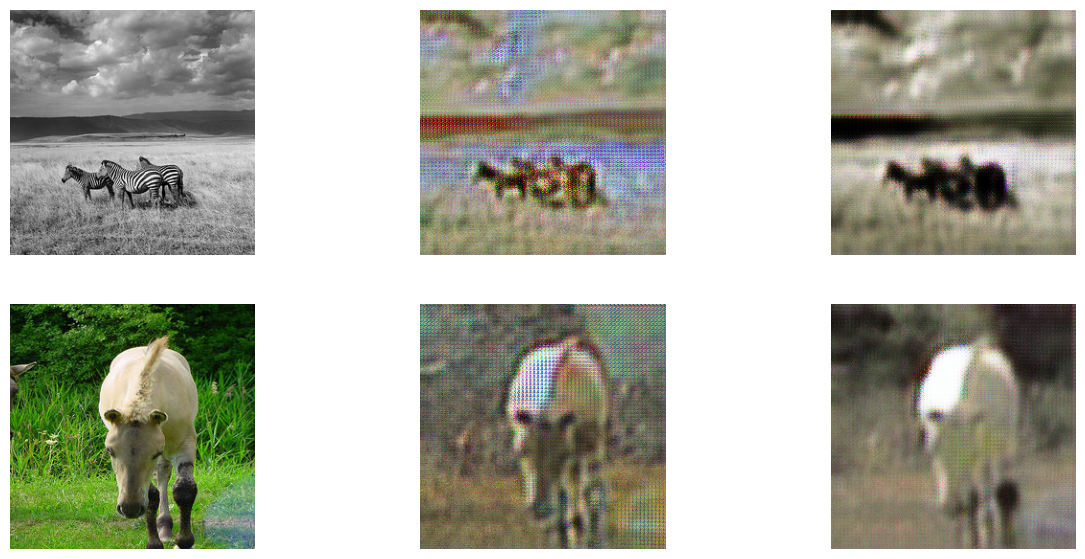

  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint
5


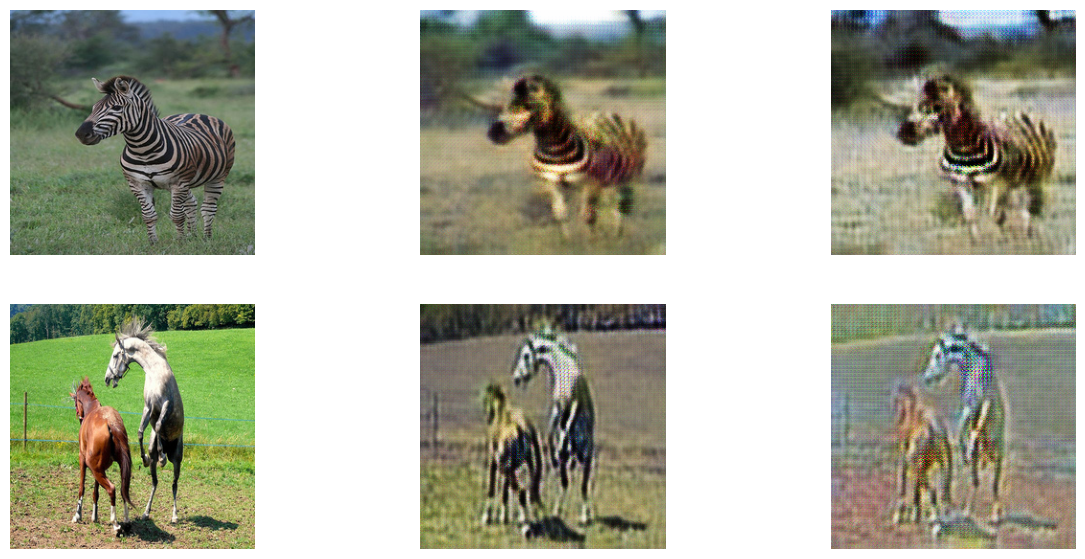

  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint
10


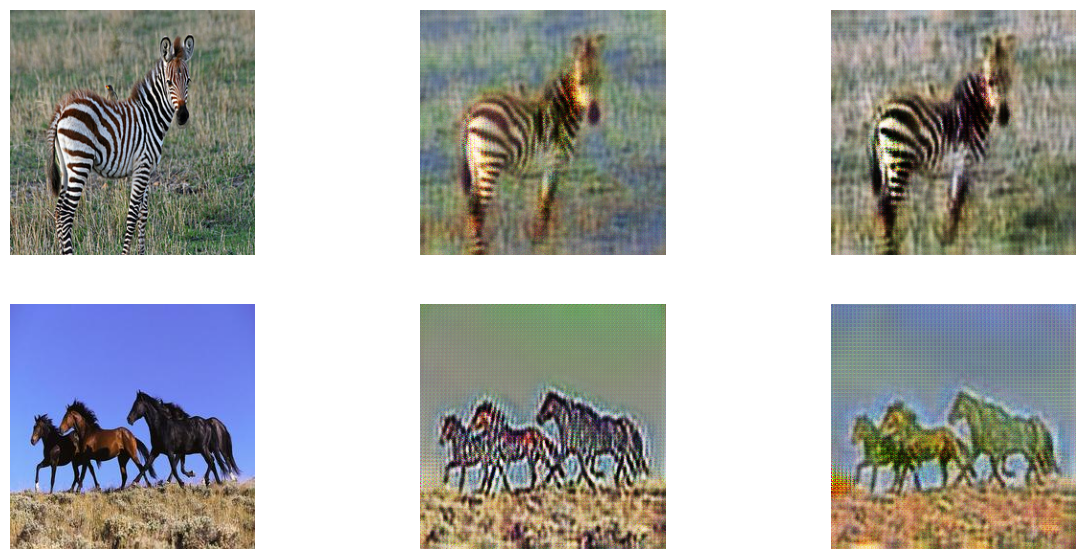

  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint
15


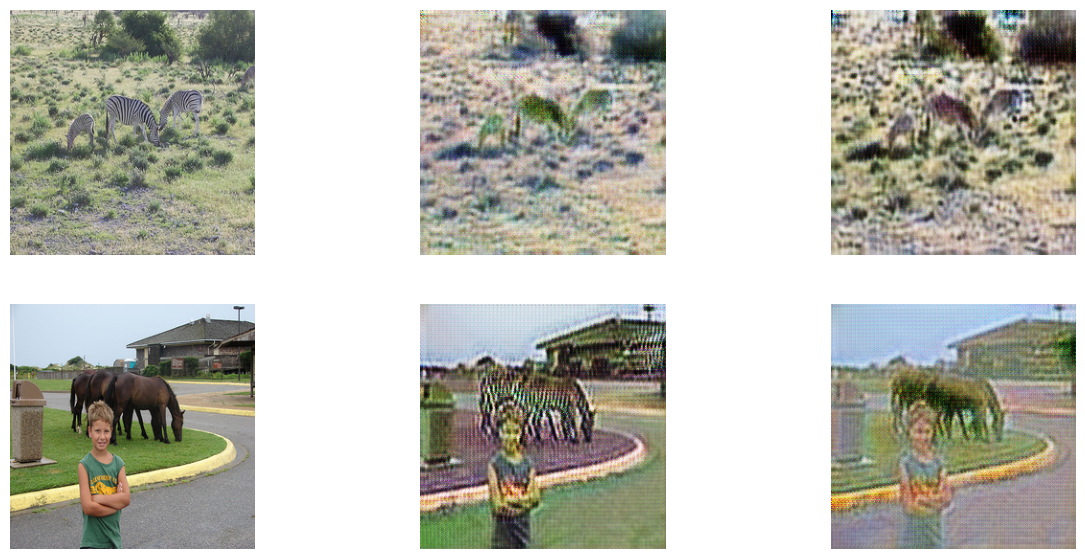

  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint
20


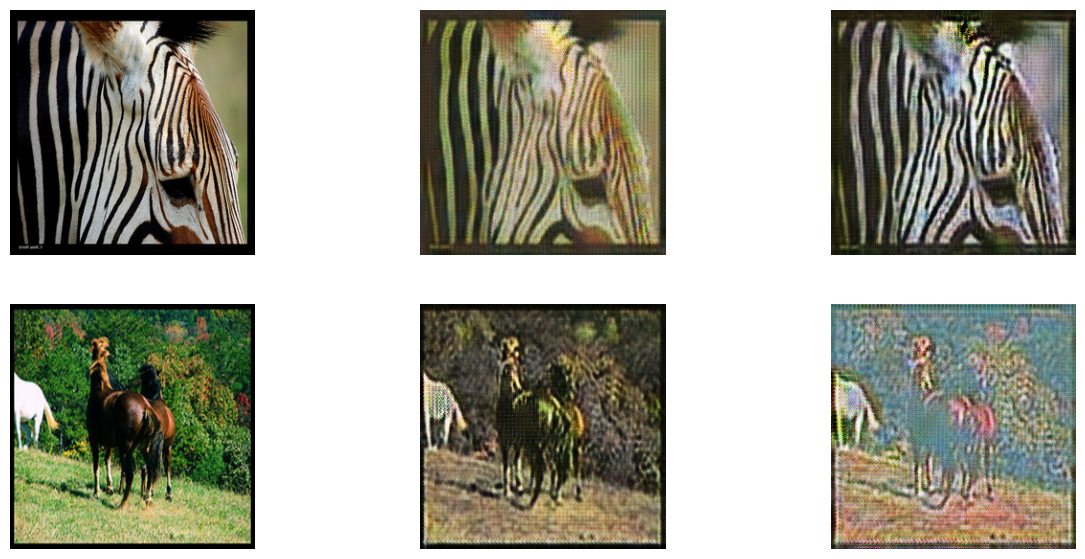

  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/167 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/167 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [32]:
for epoch in range(NUM_EPOCHS):
    train_fn(disc_H, disc_Z, gen_Z, gen_H, train_loader, opt_disc, opt_gen, L1, MSE, d_scaler, g_scaler)
    
    
    if SAVE_MODEL:
        print("=> Saving checkpoint")
        save_checkpoint(gen_H, opt_gen, CHECKPOINT_GEN_H)
        save_checkpoint(gen_Z, opt_gen, CHECKPOINT_GEN_Z)
        save_checkpoint(disc_H, opt_disc, CHECKPOINT_DISC_H)
        save_checkpoint(disc_Z, opt_disc, CHECKPOINT_DISC_Z)
        
    if epoch % 5 == 0:
        print(epoch)
        show_some_examples(gen_Z, gen_H, val_loader)

In [14]:
MSE.item()

AttributeError: 'MSELoss' object has no attribute 'item'

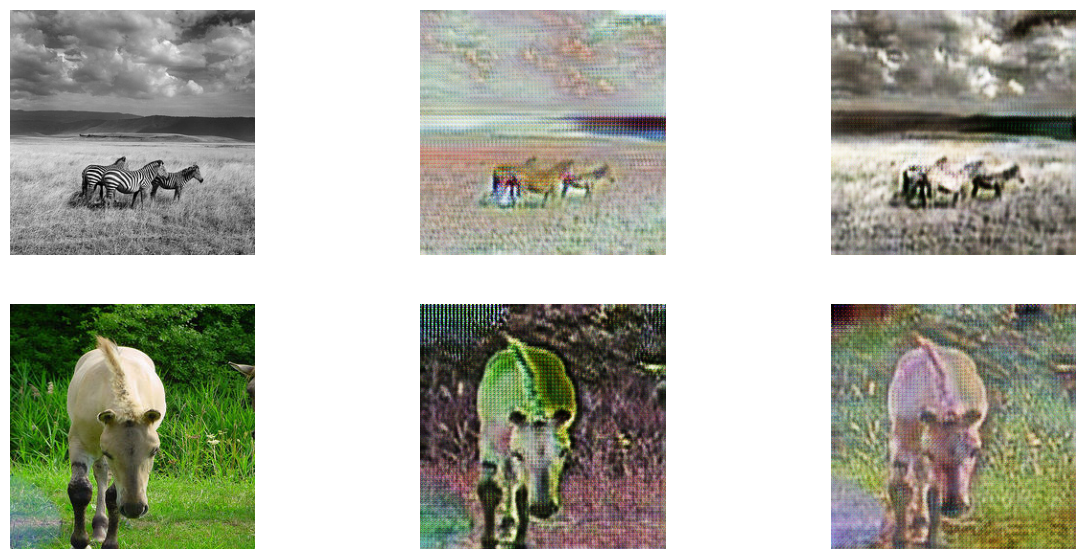

In [12]:
show_some_examples(gen_Z, gen_H, val_loader)